|------------------------------------------------------------------------------|
|--------------SOLUCIÓN DIFERENCIAS FINITAS TRADICIONALES IMPLÍCITO------------|
|------------------------------------------------------------------------------|
tiempo de simulacion: 0.4 dias
tiempo de simulacion: 0.8 dias
tiempo de simulacion: 1.2 dias
tiempo de simulacion: 1.6 dias
tiempo de simulacion: 2.0 dias
tiempo de simulacion: 2.4 dias
tiempo de simulacion: 2.8 dias
tiempo de simulacion: 3.2 dias
tiempo de simulacion: 3.6 dias
tiempo de simulacion: 4.0 dias
tiempo de simulacion: 4.4 dias
tiempo de simulacion: 4.8 dias
tiempo de simulacion: 5.2 dias
tiempo de simulacion: 5.6 dias
tiempo de simulacion: 6.0 dias
tiempo de simulacion: 6.4 dias
tiempo de simulacion: 6.8 dias
tiempo de simulacion: 7.2 dias
tiempo de simulacion: 7.6 dias
tiempo de simulacion: 8.0 dias
tiempo de simulacion: 8.4 dias
tiempo de simulacion: 8.8 dias
tiempo de simulacion: 9.2 dias
tiempo de simulacion: 9.6 dias
tiempo de sim

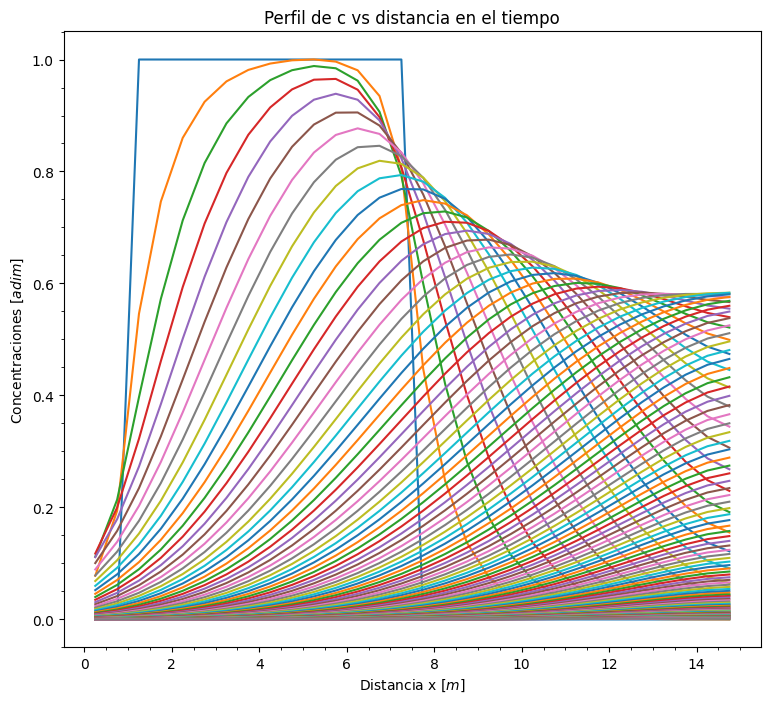

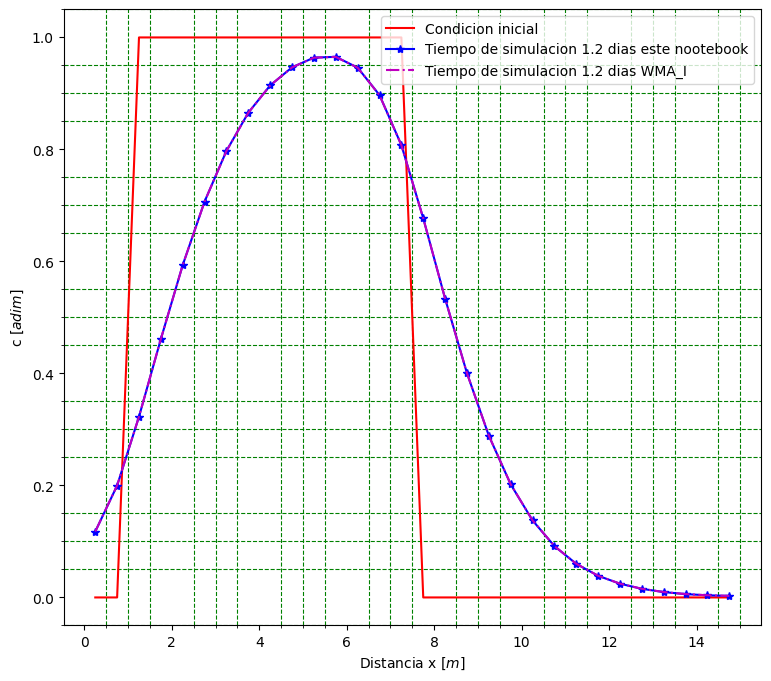

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar  7 14:00:34 2024

@author: leo_teja
"""

#------------------------------------------------------------------------------------------#
#----------------------------------- Bibliotecas a utilizar -------------------------#
#------------------------------------------------------------------------------------------#

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import lil_matrix           #Importación del modulo scipy que convierte una matriz en una lista
from scipy.sparse import csr_matrix           #Importación del modulo csr_matrix para emplear el método CSR para la solución del sistema de ecuaciones
from scipy.sparse.linalg import spsolve  

from time import time                         #Importación del modulo time para determinar los tiempos de cálculo


#------------------------------------------------------------------------------------------#
#------------- Datos de entrada: Fuente hoja de cálculo excel WMA -------------------------#
#------------------------------------------------------------------------------------------#

long_x = 15.0                         #Longitud en "x" en [ft]
teta = 1.0                            #Adimensional [Adim.]
DH = 1.0                              #coefciente de difusión??? [m2/dia]
r = -0.02                             #recarga o descarga  [1/dia]
cr = 0.0                              #concentración de recarga [Adim.]
nds_x = 30                            #Cantidad de nodos en "x"
t_sim = 50.8                          #Tiempo de simulación (dias)
dt = 0.4                              #Paso de tiempo (dias)
q_inf = 1.0                           #Condición de frontera izquierda en [m/dia]
c_inf = 0.0                           #Condición de frontera izquierda en [m/dia]
c_out = 0.0                           #Condición de frontera derecha en [m/dia]
long_ini_cini = 1.0                   #Posición inicial de las condiciones iniciales de concentraciones en [ft]
long_fin_cini = 7.5                   #Posición final de las condiciones iniciales de concentraciones en [ft]



#------------------------------------------------------------------------------------------#
#--------------------------- Malla de simulación espcio y tiempo ----------------------------#
#------------------------------------------------------------------------------------------#

delta_x = long_x/nds_x                                           #Delta en "x" considerando un espaciamiento homogéneo entre nodos en [m]
xi = np.linspace((delta_x)/(2), long_x-(delta_x/2), nds_x)        #Posición de los nodos en "i" en [m]
x_frntrs = np.linspace(0, long_x, nds_x+1)                      #Posición de las fronteras "i+1/2 e i-1/2" en [m]

t = np.arange(0, t_sim+0.01, dt)           #Vector de tiempo en [Días]
nt = len(t)-1                             #numero de pasos de tiempo 


#------------------------------------------------------------------------------------------#
#---------- Calculando los valores de q para cada nodo y fronteras de la celdas ----------------#
#------------------------------------------------------------------------------------------#

q_frnts = np.zeros(nds_x+1)                       #Vector de q en las fronteras de las celdas en [m/dias]
q_i = np.zeros(nds_x)                             #Vector de q en los nodos o centros "i" en [m/dias]
for i in range(0, nds_x+1):
    if i == 0:
        q_frnts[i] = q_inf                        #Valor de q en 0-1/2 de la primera frontera (que sería la condición de frontera izquierda de qinf)
    else:
        q_frnts[i] = q_frnts[i-1]+(r*delta_x)    #Valor de q en las demás fronteras en i-1/2, i+1/2 
        q_i[i-1] = (q_frnts[i-1]+q_frnts[i])/2   #Valor de q en los nodos i

#------------------------------------------------------------------------------------------#
#------ Definiendo vectores y matriz  para el sistema de eq lineales ---------------------#
#------------------------------------------------------------------------------------------#

TE = np.zeros(nds_x)                          #Vector de transmisibilidad en i+1/2
TW = np.zeros(nds_x)                          #Vector de transmisibilidad en -1/2
TC = np.zeros(nds_x)                          #Vector central C
B = np.zeros(nds_x)                           #Vector de valores conocidos, lado derecho 
mtrz_coef = np.zeros((nds_x, nds_x))          #Matriz de coeficientes para la solución del sistema de ecuaciones
c_ini = np.zeros(nds_x)                       #Vector de condiciones iniciales de c
c_n = np.zeros(nds_x)                         #Vector de valor de c a un paso de tiempo n (necesario para la solución del sistema de ecuaciones)
c_v = np.zeros(nds_x)                         #Vector de valor de c a un paso de tiempo n+1
solcnsImp_c = np.zeros((nt+1, nds_x))            #Matriz de guardado de las c para cada paso de tiempo y en toda la malla 1D (incluyendo las condiciones iniciales al tiempo cero)


#------------------------------------------------------------------------------------------#
#---------------------------- Definiendo condiciones iniciales ----------------------------#
#------------------------------------------------------------------------------------------#

for i in range(0, nds_x):
    if xi[i] >= long_ini_cini and xi[i] <= long_fin_cini:   #Si los nodos en xi están dentro de este rango se tiene la condición inicial de c = 1
        c_ini[i] = 1
    else:
        c_ini[i] = 0                          #Si los nodos en xi no se encuentran dentro del rango se tiene la condición inicial de c = 0

c_n[:] = c_ini[:]                             #Inicializando el vector c_n
solcnsImp_c[0][:] = c_n[:]                       #Guardando el valor de las condiciones iniciales en la matriz de soluciones de c


print("|------------------------------------------------------------------------------|")
print("|--------------SOLUCIÓN DIFERENCIAS FINITAS TRADICIONALES IMPLÍCITO------------|")
print("|------------------------------------------------------------------------------|")

#------------------------------------------------------------------------------------------#
#------------------------ Inicio del ciclo solución en el tiempo --------------------------#
#------------------------------------------------------------------------------------------#
tiempoComputo_inicial = time()       

for ti in range(0, nt):
        
    #--------------------------------------------------------------------------------------#
    #----------------- Calculando transmisibilidades en i, i+1/2 e i-1/2 ------------------#
    #--------------------------------------------------------------------------------------# 
    
    for i in range(0, nds_x):                                                               #Se calculó la transmisibilidad en todos los nodos ya que se considera el nodo fantasma para las condiciones de frontera, entonces, el nodo en nx+1/2 se utilizará en B
        TE[i] = (q_i[i])/(2*delta_x)-DH/delta_x**2                             #Transmisibilidad en xi+1/2
        TW[i] =-(q_i[i])/(2*delta_x)-DH/delta_x**2                              #Transmisibilidad en xi-1/2    
        TC[i] = ((2*DH)/delta_x**2+r+(teta/dt))
        
        if i==0:
            cte=(DH/delta_x-q_inf/2)/(DH/delta_x+q_inf/2)
            # TC[i]=TC[i]-TW[i]        #Dirichtlet
            TC[i]=TC[i]+cte*TW[i]        #Robin??

        if i==nds_x-1:
            TC[i]=TC[i]+TE[i]
            
        if i == 0:
            # B[i] =  ((teta/dt)*(c_n[i]))+(r*cr)-2*TW[i]*c_inf              #Condición de frontera izquierda Dirichlet (primera clase)
            B[i] =  ((teta/dt)*(c_n[i]))+(r*cr)
        else:
            B[i] =  ((teta/dt)*(c_n[i]))+(r*cr)
        
    #--------------------------------------------------------------------------------------#
    #------------------------ Llenando la matriz de coeficientes ------------------------#
    #--------------------------------------------------------------------------------------# 
    
    for i in range(0, nds_x):
        mtrz_coef[i][i] = TC[i]
        
        if i < nds_x-1:    
            mtrz_coef[i][i+1] = TE[i]
        
        if i > 0:
            mtrz_coef[i][i-1] = TW[i]
    
    #--------------------------------------------------------------------------------------#
    #------------------------ Resolviendo el sistema de ecuaciones ------------------------#
    #--------------------------------------------------------------------------------------#
    
    am = lil_matrix(mtrz_coef)                                                              #Función que pasa de una matriz densa a una matriz tipo lista
    am = am.tocsr()
    solcn_cs = spsolve(am, B)                                                               #Resolviendo el sistema de ecuaciones
    
    for i in range (0, nds_x):
        c_v[i] = solcn_cs[i]                                                                #Guardando las soluciones en el vector c_v
        
    solcnsImp_c[ti+1][:] = c_v[:]                                                              #Guardando las soluciones en la matriz de c para cada paso de tiempo
    c_n[:] = c_v[:]                                                                         #Guardando el valor de c al tiempo n que se utilizará en el siguiente paso de tiempo

    print("tiempo de simulacion: " +str(round(dt*(ti+1),2))+" dias" )


#------------------------------------------------------------------------------------------#
#---------------------- Tiempo de ejecución del modelo de simulación ----------------------#
#------------------------------------------------------------------------------------------# 

tiempoComputo_final=time()                                                                         #Toma el valor de tiempo final de ejecución, para  calcuar el tiempo total de la simulación
tiempo_ejec_seg=(tiempoComputo_final-tiempoComputo_inicial)                                               #Calcula el tiempo total de simulación, pasado a segundos
tiempo_ejec_min=(tiempoComputo_final-tiempoComputo_inicial)/60                                            #Calcula el tiempo total de simulación, pasado a minutos
print("\nTiempo de Ejecución:",tiempo_ejec_seg, "[Segundos]","\t", tiempo_ejec_min, "[Minutos]\n")
print("|------------------------------------------------------------------------------|")
print("|------------------ FIN DE LA SIMULACIÓN DIFF TRAD IMP  -------------------------|")
print("|------------------------------------------------------------------------------|")


#------------------------------------------------------------------------------------------#
#--------------------------- Graficando todos los resultados ------------------------------#
#------------------------------------------------------------------------------------------#

plt.figure('DiffTrad_Imp',figsize=(9,8))
plt.style.use('fast')
plt.minorticks_on()
plt.title('Perfil de c vs distancia en el tiempo')
for i in range(0, nt+1):
    plt.plot(xi, solcnsImp_c[i][:]) 
# plt.legend(loc=4)
plt.xlabel("Distancia x [$m$]")
plt.ylabel("Concentraciones [$adim$]")                                                                        
plt.grid(True,which='major', color='w', linestyle='-')
plt.grid(True, which='minor', color='w', linestyle='--')


#--------------------------------------------------------------------------------------------------#
#------------------------ Graficando un solo resultado y comparandolo vs WMAI ----------------------#
#---------------------------------------------------------------------------------......---------#

plt.figure('comparativa_01',figsize=(9,8))
WMA_I=pd.read_excel('comparativa.xlsx', sheet_name='WMA_I')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
data_set = WMA_I.iloc[13:,9:39].to_numpy()
#WMA_I
tsel=3    #tiempo seleccionado de hoja excel
plt.plot(xi, solcnsImp_c[0][:], "-r"  , label="Condicion inicial")
plt.plot(xi, solcnsImp_c[tsel][:], "-b*", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias este nootebook")
plt.plot(xi, data_set[tsel][:], "-.m", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias WMA_I" )
plt.xlabel("Distancia x [$m$]"), plt.ylabel("c $[adim]$")
plt.legend(loc=0); plt.minorticks_on()
plt.grid(True,which='major', color='w', linestyle='-')
plt.grid(True, which='minor', color='g', linestyle='--')

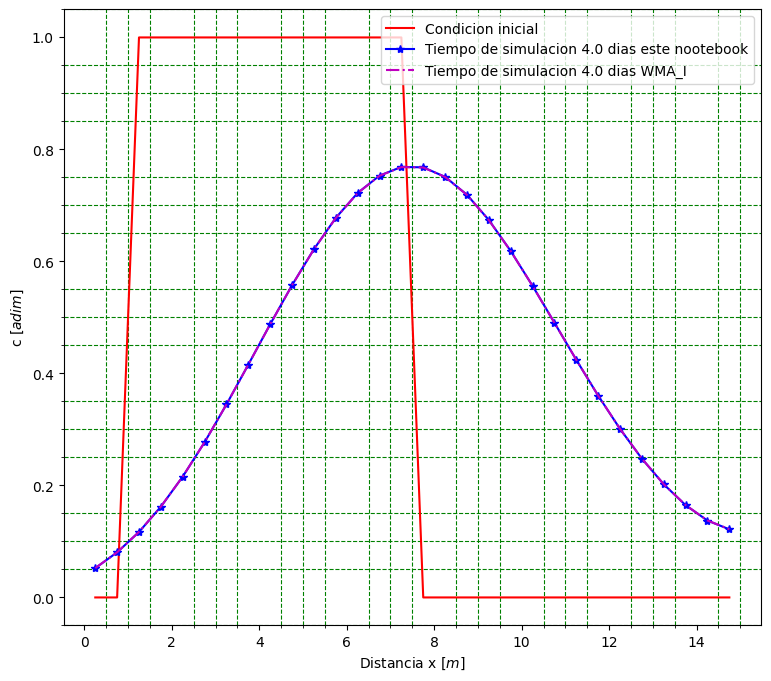

In [2]:
plt.figure('comparativa_01',figsize=(9,8))
WMA_I=pd.read_excel('comparativa.xlsx', sheet_name='WMA_I')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
data_set = WMA_I.iloc[13:,9:39].to_numpy()
#WMA_I
tsel=10    #tiempo seleccionado de hoja excel
plt.plot(xi, solcnsImp_c[0][:], "-r"  , label="Condicion inicial")
plt.plot(xi, solcnsImp_c[tsel][:], "-b*", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias este nootebook")
plt.plot(xi, data_set[tsel][:], "-.m", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias WMA_I" )
plt.xlabel("Distancia x [$m$]"), plt.ylabel("c $[adim]$")
plt.legend(loc=0); plt.minorticks_on()
plt.grid(True,which='major', color='w', linestyle='-')
plt.grid(True, which='minor', color='g', linestyle='--')

In [10]:
solcnsImp_c.shape

(128, 30)

In [3]:
import ipywidgets as widgets

In [14]:
def comparacion(tsel):
    plt.figure('comparativa_01',figsize=(8,6))
    WMA_I=pd.read_excel('comparativa.xlsx', sheet_name='WMA_I')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
    data_set = WMA_I.iloc[13:,9:39].to_numpy()
    #WMA_I
#    tsel=10    #tiempo seleccionado de hoja excel
    plt.plot(xi, solcnsImp_c[0][:], "-r"  , label="Condicion inicial")
    plt.plot(xi, solcnsImp_c[tsel][:], "-b*", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias este nootebook")
    plt.plot(xi, data_set[tsel][:], "-.m", label="Tiempo de simulacion "+str(round(tsel*0.4,2))+" dias WMA_I" )
    plt.xlabel("Distancia x [$m$]"), plt.ylabel("c $[adim]$")
    plt.legend(loc=0); plt.minorticks_on()
    plt.grid(True,which='major', color='w', linestyle='-')
    plt.grid(True, which='minor', color='g', linestyle='--')
    plt.show()

widgets.interactive(comparacion,
                    tsel = widgets.IntSlider(min=0, max = 127, value=0, step=1))

interactive(children=(IntSlider(value=0, description='tsel', max=127), Output()), _dom_classes=('widget-intera…